In [1]:
# TODO
# 1. open tphot, egs_candles, and egs_merged to read
# 2. match RA and DEC between egs_merged and tphot
# 3. get ID from egs_merged for matches (#2) and match to egs_candles
# 4. make catalog with all data
# note: there may be 2 matches in #2, make note of these sources. We will have to match by eye. 

# Read Data

In [93]:
## imports
# astronomy
from astropy.io import fits
from astropy.io import ascii
from astropy.coordinates import SkyCoord
import astropy.units as u
# plotting
import matplotlib.pyplot as plt
# data 
import numpy as np

In [6]:
# file paths 
path_catalogs = 'C:\\Users\\polar\\OneDrive - The University of Kansas\\AGNerds\\Catalogs'

In [12]:
# open egs_merged 
egs_merged_inf = fits.open(path_catalogs+'\\egs_merged_v1.1.fits')
egs_merged_data = egs_merged_inf[1].data
egs_merged_cols = egs_merged_inf[1].columns
egs_merged_inf.close()

In [10]:
# print all columns
# print(egs_merged_cols)

# important columns:
    # name = 'ID'; format = 'K'
    # name = 'RA'; format = 'D'; unit = 'deg'
    # name = 'DEC'; format = 'D'; unit = 'deg'
    # name = 'z_best'; format = 'D'

In [34]:
# open tphot
tphot_data = ascii.read(path_catalogs+'\\tphot.cat')
tphot_cols = tphot_data.colnames

In [33]:
# show table
# tphot_data.show_in_notebook()

# important columns:
    # name = 'ra'
    # name = 'dec'

# Match RA and DEC 

In [63]:
# get RA and DEC from tphot and make array
tphot_RA  = np.array(tphot_data['ra'])
tphot_DEC = np.array(tphot_data['dec'])
# get RA and DEC from egs_merged (already an array)
egs_merged_RA  = egs_merged_data['RA']
egs_merged_DEC = egs_merged_data['DEC']

# get coordinants 
tphot_coord = SkyCoord(ra=tphot_RA*u.deg, dec=tphot_DEC*u.deg)
egs_merged_coord = SkyCoord(ra=egs_merged_RA*u.deg, dec=egs_merged_DEC*u.deg)

In [70]:
print('Number of tphot sources:\t', len(tphot_RA))
print('Number of egs_merged sources:\t', len(egs_merged_RA))

Number of tphot sources:	 1734
Number of egs_merged sources:	 41457


In [115]:
# DOC: https://docs.astropy.org/en/stable/coordinates/matchsep.html

# idx are indices into catalog that are the closest objects to each of the coordinates in c, 
# d2d are the on-sky distances between them, and 
# d3d are the 3-dimensional distances. 
idx, d2d, d3d = egs_merged_coord.match_to_catalog_sky(tphot_coord) # idx, d2d, d3d = c.match_to_catalog_sky(catalog)

# separation constraint
max_sep = 1.0 * u.arcsec
sep_constraint = d2d < max_sep  # use on 'c' (egs_merged_coord)
idx_sep = idx[sep_constraint]   # use on 'catalog' (tphot)

# get matches
egs_merged_matches = egs_merged_coord[sep_constraint]
tphot_matches = tphot_coord[idx_sep]

# print length  
print('Number of matches:\t', len(tphot_matches))

Number of matches:	 1661


In [116]:
# test match
i=10
print(egs_merged_matches[i])
print(tphot_matches[i])

<SkyCoord (ICRS): (ra, dec) in deg
    (215.05667585, 52.8984765)>
<SkyCoord (ICRS): (ra, dec) in deg
    (215.05664, 52.898458)>


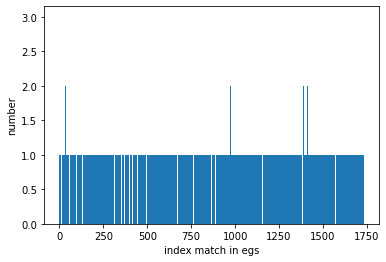

In [125]:
# histogram of matches to visualize duplicats and misses
plt.hist(idx_sep, bins=1734)
plt.xlabel('index match in egs')
plt.ylabel('number')
plt.show()